In [1]:
## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# run_google_colab = True
run_google_colab = False


In [2]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "nc-time-axis", "cftime", "climpred", "dateutil", "seaborn",
]

if run_google_colab:
    # Install missing packages if needed
    for pkg in required_packages:
        install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator


In [3]:
if run_google_colab:
    # Download necessary files if running in Google Colab
    !wget -cq https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO.py
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO_utils.py

# def setup_module_path():
module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/XRO-main'
sys.path.append(module_path)

# Import necessary modules after ensuring files are available
from XRO import XRO, xcorr, SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm
# from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


In [4]:
# prepare NPP file
npp_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_photoC_TOT_zint_100m_x1_210_x2_270_y1_-20_y2_10.nc'
npp_ds = xr.open_dataset(npp_file).sel(time=slice('1979-01', '2024-12'))
# print(npp_ds)
clim = npp_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = npp_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_photoC_TOT_zint_100m'].values, deg=2)
trend = np.polyval(coeffs, t)
npp_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# prepare SSH file
ssh_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_SSH_x1_210_x2_270_y1_-20_y2_10.nc'
ssh_ds = xr.open_dataset(ssh_file).sel(time=slice('1979-01', '2024-12'))
clim = ssh_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = ssh_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_SSH'].values, deg=2)
trend = np.polyval(coeffs, t)
ssh_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# prepare SST file
sst_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_TEMP_x1_210_x2_270_y1_-20_y2_10.nc'
sst_ds = xr.open_dataset(sst_file).sel(time=slice('1979-01', '2024-12'))
clim = sst_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = sst_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_SST'].values, deg=2)
trend = np.polyval(coeffs, t)
sst_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# prepare MLD file
mld_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_HBLT_x1_210_x2_270_y1_-20_y2_10.nc'
mld_ds = xr.open_dataset(mld_file).sel(time_counter=slice('1979-01', '2024-12'))
mld_ds = mld_ds.rename({'time_counter': 'time'})
clim = mld_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = mld_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_HBLT'].values, deg=2)
trend = np.polyval(coeffs, t)
mld_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})


In [5]:
# npp_ds['obs_photoC_TOT_zint_100m'].plot()
# ssh_ds['obs_SSH'].plot()
# sst_ds['obs_SST'].plot()
# mld_ds['obs_HBLT'].plot()

In [6]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
if run_google_colab:
    obs_file = './XRO_indices_oras5.nc'
else:
    # obs_file = '../data/XRO_indices_oras5.nc'
    obs_file = '/mnt/lustre/proj/kimyy/Dropbox/source/python/all/Modules/RO_practical-main/data/XRO_indices_oras5.nc'

obs_ds = xr.open_dataset(obs_file).sel(time=slice('1998-01', '2024-12'))
obs_RO_ds = obs_ds[['Nino34', 'WWV']]
print(obs_RO_ds)

<xarray.Dataset> Size: 6kB
Dimensions:  (time: 324)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1998-01-01 1998-02-01 ... 2024-12-01
    month    (time) int32 1kB ...
Data variables:
    Nino34   (time) float32 1kB ...
    WWV      (time) float32 1kB ...


In [7]:
# preprocessing part
# Preprocessing in LIM study:
# To preprocess the data, we remove the monthly climatological mean and linear trend from all indices, 
# apply a 3-month running average and normalization, a standard practice in LIM studies


clim = npp_ds["obs_photoC_TOT_zint_100m"].groupby("time.month").mean("time")
anom = npp_ds["obs_photoC_TOT_zint_100m"].groupby("time.month") - clim
npp_anom = npp_ds.copy()
npp_anom["obs_photoC_TOT_zint_100m"] = anom


In [8]:
# obs + npp
npp = npp_ds['obs_photoC_TOT_zint_100m'].rename('NPP')
npp_on_obs_time = npp.reindex(time=obs_RO_ds.time)
obs_ds_with_npp = obs_ds.copy()
obs_ds_with_npp['NPP'] = npp_on_obs_time

# obs + npp + ssh
ssh = ssh_ds['obs_SSH'].rename('SSH')
ssh_on_obs_time = ssh.reindex(time=obs_RO_ds.time, method='nearest', tolerance='20D')
obs_ds_with_ssh = obs_ds_with_npp.copy()
obs_ds_with_ssh['SSH'] = ssh_on_obs_time

# obs + npp + ssh + sst
# sst = sst_ds['obs_SST'].rename('SST')
# sst_on_obs_time = sst.reindex(time=obs_RO_ds.time)
# obs_ds_with_all = obs_ds_with_ssh.copy()
# obs_ds_with_all['SST'] = sst_on_obs_time

# mld = mld_ds['obs_HBLT'].rename('MLD').rename({'time_counter': 'time'})
mld = mld_ds['obs_HBLT'].rename('MLD')
mld_on_obs_time = mld.reindex(time=obs_RO_ds.time, method='nearest', tolerance='20D')
obs_ds_with_mld = obs_ds_with_ssh.copy()
obs_ds_with_mld['MLD'] = mld_on_obs_time

sst = sst_ds['obs_SST'].rename('SST')
sst_on_obs_time = sst.reindex(time=obs_RO_ds.time, method='nearest', tolerance='20D')
obs_ds_with_all = obs_ds_with_mld.copy()
obs_ds_with_all['SST'] = sst_on_obs_time


In [9]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('1998-01', '2022-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

In [10]:
# Choose variables

# obs_XRO_ds = obs_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]

obs_XRO_ds = obs_ds_with_npp[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
obs_NRO_ds = obs_ds_with_npp[['Nino34', 'WWV']]

obs_XRO_NPP_ds = obs_ds_with_npp[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'NPP']]
obs_XRO_NPP_ds
obs_NRO_NPP_ds = obs_ds_with_npp[['Nino34', 'WWV', 'NPP']]
obs_NRO_NPP_ds

obs_XRO_NPP_SST_ds = obs_ds_with_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'SST', 'NPP']]
obs_NRO_NPP_SST_ds = obs_ds_with_all[['Nino34', 'WWV', 'SST', 'NPP']]

obs_XRO_ALL_ds = obs_ds_with_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'SST', 'SSH', 'MLD', 'NPP']]
obs_NRO_ALL_ds = obs_ds_with_all[['Nino34', 'WWV', 'SST', 'SSH', 'MLD', 'NPP']]


In [11]:
slice_train = slice('1998-01', '2024-12')
slice_verif = slice('1998-01', '2024-12')

XRO_NPP_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)


In [12]:
ccr_XRO_Nino34_ds = xcorr(obs_XRO_NPP_ds, obs_XRO_NPP_ds['Nino34'], maxlags=36)
ccr_XRO_NPP_ds = xcorr(obs_XRO_NPP_ds, obs_XRO_NPP_ds['NPP'], maxlags=36)

In [13]:

fit_XRO_NPP_train = XRO_NPP_ac1.fit_matrix(obs_XRO_NPP_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_NPP_insample_fcst = XRO_NPP_ac1.reforecast(fit_ds=fit_XRO_NPP_train, init_ds=obs_XRO_NPP_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_insample = calc_forecast_skill(XRO_NPP_insample_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_NPP_insample = calc_forecast_skill(XRO_NPP_insample_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11 12], inactive=[]
X_active shape: (13, 324), total X shape: (13, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 324), total X shape: (12, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 324), total X shape: (12, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape:

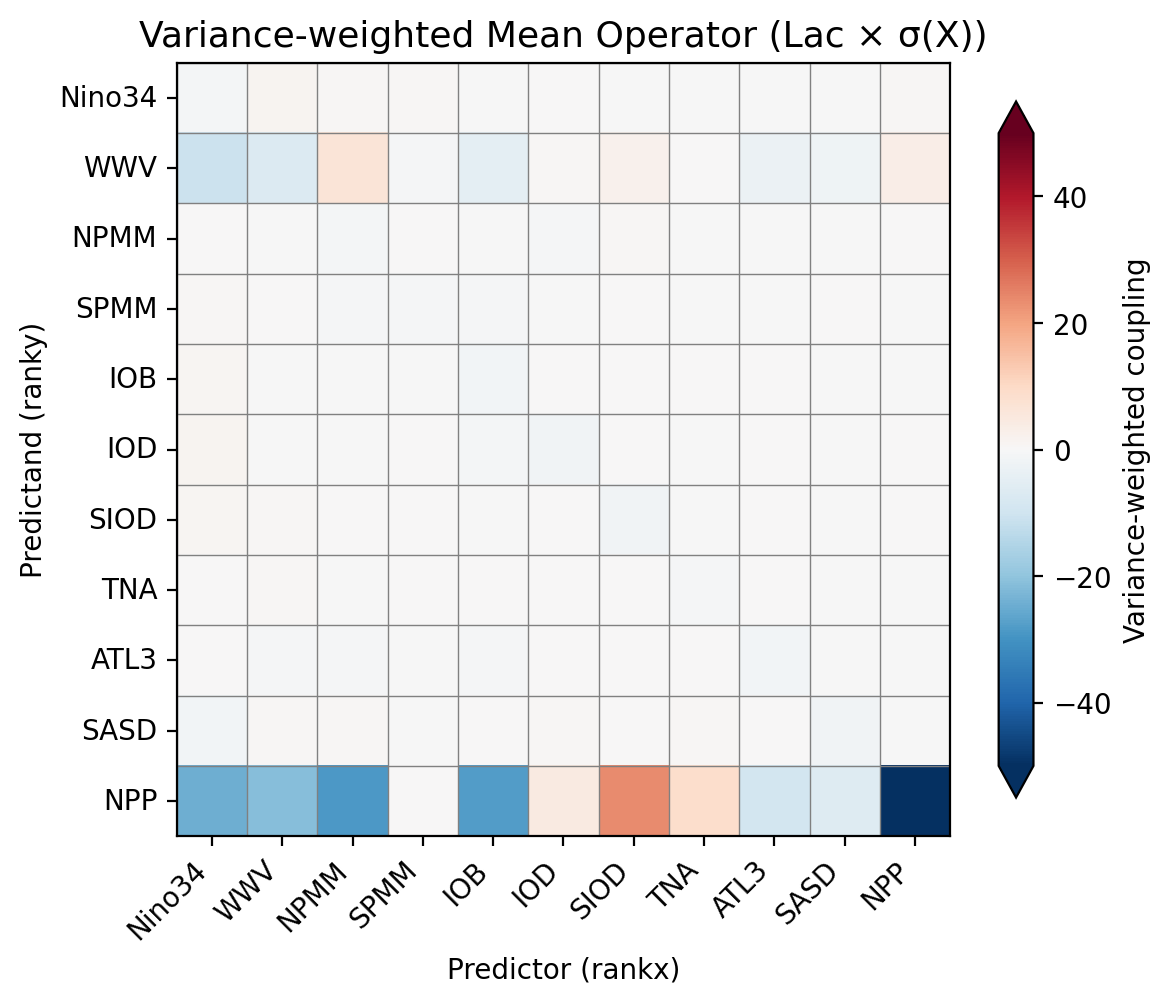

In [14]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 
           'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'NPP']

fit_ds = fit_XRO_NPP_train

fit_ds = fit_ds.assign_coords(rankx=labels, ranky=labels)

# --- Mean operator over annual cycle ---
L = fit_ds['Lac'].mean('cycle')

# --- Compute predictor standard deviations (time dimension of training data) ---
X_std = fit_ds['X'].std('time')  # (rankx,)
# 안전하게 크기 맞춰주기
X_std = xr.DataArray(X_std, dims=['rankx'], coords={'rankx': labels})

# --- Variance-weighted operator ---
L_weighted = L * X_std  # broadcasting (ranky, rankx)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(L_weighted, cmap='RdBu_r', vmin=-50, vmax=50, origin='upper')

# axis ticks
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, va='center')

# colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.9, extend='both', label='Variance-weighted coupling')

# gridlines
ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

ax.set_title('Variance-weighted Mean Operator (Lac × σ(X))', fontsize=13)
ax.set_xlabel('Predictor (rankx)')
ax.set_ylabel('Predictand (ranky)')

plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# Define variable names in correct order
var_names = [
    'Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD',
    'SIOD', 'TNA', 'ATL3', 'SASD', 'NPP'
]

nvar = len(var_names)
link_mask = np.ones((nvar, nvar), dtype=int)

# Find index of target variable (NPP)
idx_NPP = var_names.index('NPP')

# --- Apply structural constraint ---
# (1) Allow all variables to influence NPP
link_mask[:, idx_NPP] = 1
# (2) Block NPP from influencing other variables
link_mask[idx_NPP, :] = 0
# (3) Keep NPP's self-feedback (autonomous term)
link_mask[idx_NPP, idx_NPP] = 1

# --- Check structure visually ---
print(pd.DataFrame(link_mask, index=var_names, columns=var_names))

        Nino34  WWV  NPMM  SPMM  IOB  IOD  SIOD  TNA  ATL3  SASD  NPP
Nino34       1    1     1     1    1    1     1    1     1     1    1
WWV          1    1     1     1    1    1     1    1     1     1    1
NPMM         1    1     1     1    1    1     1    1     1     1    1
SPMM         1    1     1     1    1    1     1    1     1     1    1
IOB          1    1     1     1    1    1     1    1     1     1    1
IOD          1    1     1     1    1    1     1    1     1     1    1
SIOD         1    1     1     1    1    1     1    1     1     1    1
TNA          1    1     1     1    1    1     1    1     1     1    1
ATL3         1    1     1     1    1    1     1    1     1     1    1
SASD         1    1     1     1    1    1     1    1     1     1    1
NPP          0    0     0     0    0    0     0    0     0     0    1


In [17]:

fit_XRO_NPP_linked_train = XRO_NPP_ac1.fit_matrix(obs_XRO_NPP_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'], link_mask=link_mask)

XRO_NPP_linked_fcst = XRO_NPP_ac1.reforecast(fit_ds=fit_XRO_NPP_linked_train, init_ds=obs_XRO_NPP_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')


acc_XRO_NPP_linked = calc_forecast_skill(XRO_NPP_linked_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_NPP_linked = calc_forecast_skill(XRO_NPP_linked_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))



In [18]:
ccr_XRO_Nino34_ds = xcorr(obs_XRO_NPP_ds, obs_XRO_NPP_ds['Nino34'], maxlags=36)
ccr_XRO_NPP_ds = xcorr(obs_XRO_NPP_ds, obs_XRO_NPP_ds['NPP'], maxlags=36)

NameError: name 'acc_LRO_NPP_insample' is not defined

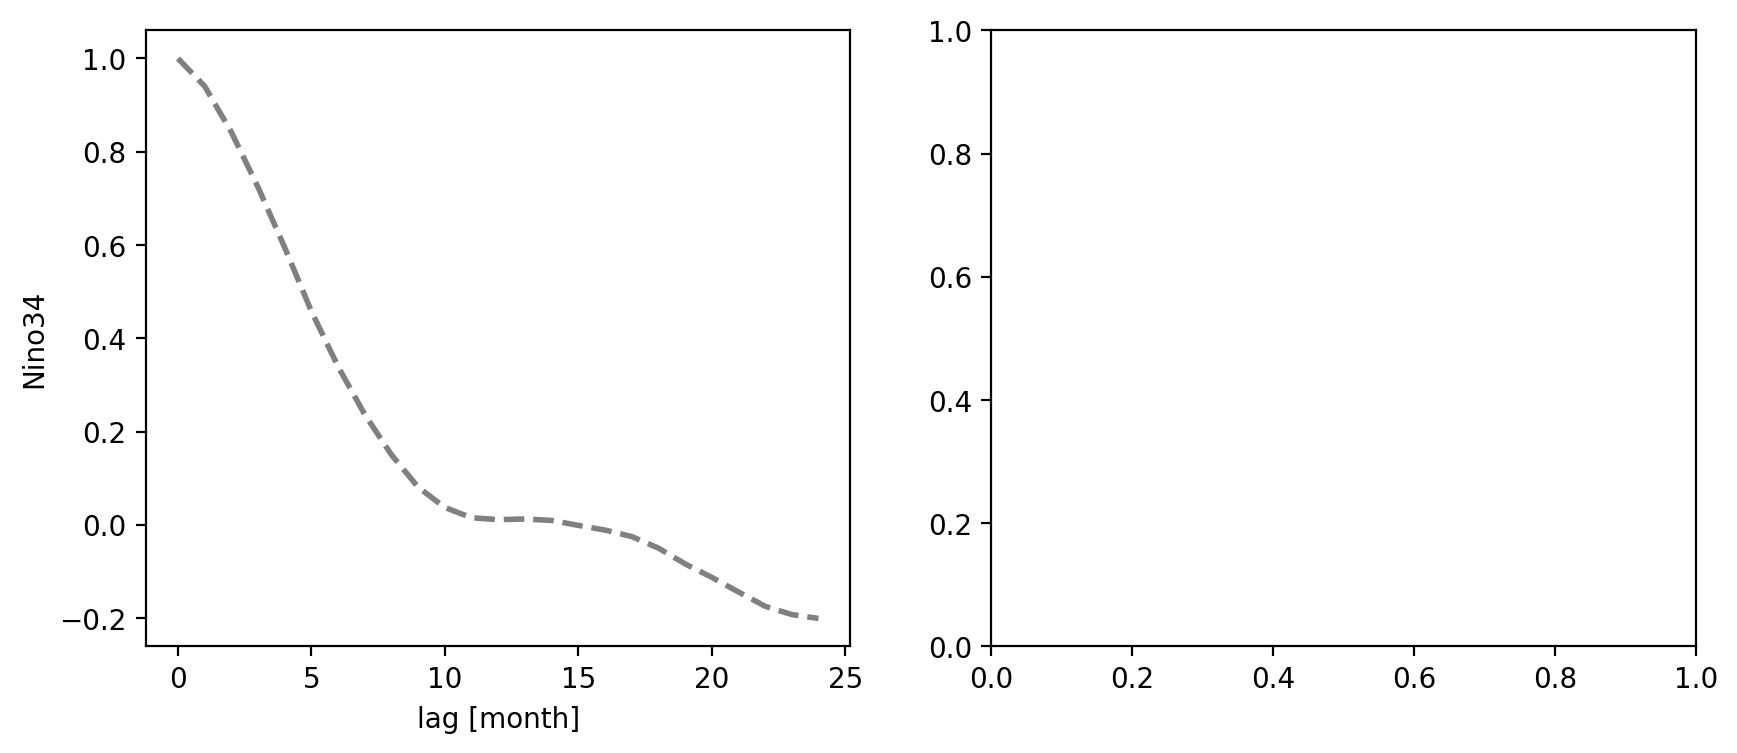

In [19]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
acc_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
acc_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)
acc_XRO_NPP_linked[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_link', c='black', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
rmse_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
rmse_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)
rmse_XRO_NPP_linked[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_link', c='black', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


In [ ]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
acc_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
acc_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)
acc_XRO_NPP_linked[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_link', c='black', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
rmse_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
rmse_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)
rmse_XRO_NPP_linked[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_link', c='black', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )


ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


In [ ]:
XRO_NPP_SST_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)

fit_XRO_NPP_SST_train = XRO_NPP_SST_ac1.fit_matrix(obs_XRO_NPP_SST_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_NPP_SST_insample_fcst = XRO_NPP_SST_ac1.reforecast(fit_ds=fit_XRO_NPP_SST_train, init_ds=obs_XRO_NPP_SST_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_SST_insample = calc_forecast_skill(XRO_NPP_SST_insample_fcst, obs_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_NPP_SST_insample = calc_forecast_skill(XRO_NPP_SST_insample_fcst, obs_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

fit_NRO_NPP_SST_train = XRO_NPP_SST_ac1.fit_matrix(obs_NRO_NPP_SST_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_SST_insample_fcst = XRO_NPP_SST_ac1.reforecast(fit_ds=fit_NRO_NPP_SST_train, init_ds=obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_SST_insample = calc_forecast_skill(NRO_NPP_SST_insample_fcst, obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_NRO_NPP_SST_insample = calc_forecast_skill(NRO_NPP_SST_insample_fcst, obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(obs_NRO_NPP_SST_ds, maskNT=[], maskNH=[])

fit_LRO_NPP_SST_train = XRO_NPP_SST_ac1.fit_matrix(obs_NRO_NPP_SST_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_SST_insample_fcst = XRO_NPP_SST_ac1.reforecast(fit_ds=fit_LRO_NPP_SST_train, init_ds=obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_SST_insample = calc_forecast_skill(LRO_NPP_SST_insample_fcst, obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_LRO_NPP_SST_insample = calc_forecast_skill(LRO_NPP_SST_insample_fcst, obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

In [ ]:
import pandas as pd

# Define variable names in correct order
var_names = [
    'Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD',
    'SIOD', 'TNA', 'ATL3', 'SASD', 'SST', 'NPP'
]

nvar = len(var_names)
link_mask = np.ones((nvar, nvar), dtype=int)

# Find index of target variable (NPP)
idx_NPP = var_names.index('NPP')
idx_SST = var_names.index('SST')
# --- Apply structural constraint ---
# (1) Allow local variable to influence NPP
link_mask[:, idx_NPP] = 0
link_mask[idx_SST, idx_NPP] = 1
# (2) Block NPP from influencing other variables
link_mask[idx_NPP, :] = 0
# # (2-1) Block SST from influencing other variables
# link_mask[idx_SST, :] = 0
# (3) Keep NPP's self-feedback (autonomous term)
link_mask[idx_NPP, idx_NPP] = 1
# # (3-1) Keep NPP's self-feedback (autonomous term)
# link_mask[idx_SST, idx_SST] = 1
# (4) Keep NPP's feedback to local variables (SST here)
link_mask[idx_NPP, idx_SST] = 1
# # (4-1) Keep SST's feedback to NPP
# link_mask[idx_SST, idx_NPP] = 1


# --- Check structure visually ---
print(pd.DataFrame(link_mask, index=var_names, columns=var_names))

In [ ]:

fit_XRO_NPP_SST_linked_train = XRO_NPP_ac1.fit_matrix(obs_XRO_NPP_SST_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'], link_mask=link_mask)

XRO_NPP_SST_linked_fcst = XRO_NPP_ac1.reforecast(fit_ds=fit_XRO_NPP_SST_linked_train, init_ds=obs_XRO_NPP_SST_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')


acc_XRO_NPP_SST_linked = calc_forecast_skill(XRO_NPP_SST_linked_fcst, obs_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_NPP_SST_linked = calc_forecast_skill(XRO_NPP_SST_linked_fcst, obs_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))



In [ ]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
acc_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
acc_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)
acc_XRO_NPP_SST_linked[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_SST_link', c='black', lw=2)

ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
rmse_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
rmse_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)
rmse_XRO_NPP_SST_linked[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_SST_link', c='black', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


In [ ]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
acc_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
acc_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)
acc_XRO_NPP_SST_linked[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_SST_link', c='black', lw=2)

ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
rmse_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
rmse_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)
rmse_XRO_NPP_SST_linked[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_SST_link', c='black', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1998-2024)')
ax.legend()


In [ ]:
slice_train2 = slice('1998-01', '2023-12')

XRO_ALL_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)

fit_XRO_ALL_train = XRO_ALL_ac1.fit_matrix(obs_XRO_ALL_ds.sel(time=slice_train2), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_ALL_insample_fcst = XRO_ALL_ac1.reforecast(fit_ds=fit_XRO_ALL_train, init_ds=obs_XRO_ALL_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_ALL_insample = calc_forecast_skill(XRO_ALL_insample_fcst, obs_XRO_ALL_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_ALL_insample = calc_forecast_skill(XRO_ALL_insample_fcst, obs_XRO_ALL_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

fit_NRO_ALL_train = XRO_ALL_ac1.fit_matrix(obs_NRO_ALL_ds.sel(time=slice_train2), maskNT=['T2'], maskNH=['T2'])
NRO_ALL_insample_fcst = XRO_ALL_ac1.reforecast(fit_ds=fit_NRO_ALL_train, init_ds=obs_NRO_ALL_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_ALL_insample = calc_forecast_skill(NRO_ALL_insample_fcst, obs_NRO_ALL_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_NRO_ALL_insample = calc_forecast_skill(NRO_ALL_insample_fcst, obs_NRO_ALL_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(obs_NRO_ALL_ds, maskNT=[], maskNH=[])

fit_LRO_ALL_train = XRO_ALL_ac1.fit_matrix(obs_NRO_ALL_ds.sel(time=slice_train2), maskNT=[], maskNH=[])
LRO_ALL_insample_fcst = XRO_ALL_ac1.reforecast(fit_ds=fit_LRO_ALL_train, init_ds=obs_NRO_ALL_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_ALL_insample = calc_forecast_skill(LRO_ALL_insample_fcst, obs_NRO_ALL_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_LRO_ALL_insample = calc_forecast_skill(LRO_ALL_insample_fcst, obs_NRO_ALL_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

In [ ]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
acc_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
acc_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
rmse_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
rmse_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


In [ ]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
acc_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
acc_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
rmse_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
rmse_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 40.01, step=5))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1998-2024)')
ax.legend()


### 5.2 Compare between XRO-NPP and nRO-NPP, ensemble simulations

In [ ]:
XRO_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_train, 
                                              init_ds=obs_XRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_train, 
                                              init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_train, 
                                              init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
XRO_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_XRO_ann_train, 
                                              init_ds=obs_XRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_NRO_ann_train, 
                                              init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_LRO_ann_train, 
                                              init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_ann stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_ann stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_ann stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
XRO_NPP_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_NPP_train, 
                                              init_ds=obs_XRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_NPP_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_NPP_train, 
                                              init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_NPP_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_NPP_train, 
                                              init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([0., 600.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
XRO_NPP_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_XRO_NPP_ann_train, 
                                              init_ds=obs_XRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [ ]:
NRO_NPP_ann_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_NPP_ann_train, 
                                              init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [ ]:
LRO_NPP_ann_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_NPP_ann_train, 
                                              init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_ann_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_ann_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_ann_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_ann_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_ann_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([0., 600.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
XRO_NPP_SST_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_NPP_SST_train, 
                                              init_ds=obs_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_NPP_SST_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_NPP_SST_train, 
                                              init_ds=obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_NPP_SST_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_NPP_SST_train, 
                                              init_ds=obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_SST_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_SST_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_SST_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_SST_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_SST_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_SST stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_SST_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_SST_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_SST_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_SST_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_SST_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_SST stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([0., 600.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
# nstep = 50 case (not critical)

import time

start_time = time.time()

XRO_ALL_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_ALL_train, 
                                              init_ds=obs_XRO_ALL_ds.sel(time=slice_verif), 
                                              n_month=24, nstep=50, ncopy=500, noise_type='red')
NRO_ALL_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_ALL_train, 
                                              init_ds=obs_NRO_ALL_ds.sel(time=slice_verif), 
                                              n_month=24, nstep=50, ncopy=500, noise_type='red')
LRO_ALL_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_ALL_train, 
                                              init_ds=obs_NRO_ALL_ds.sel(time=slice_verif), 
                                              n_month=24, nstep=50, ncopy=500, noise_type='red')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reforecast: ' + str(elapsed_time))

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_ALL_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_ALL_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_ALL_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_ALL_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_ALL_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_ALL stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_ALL stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_ALL stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_ALL_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_ALL_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_ALL_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_ALL_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_ALL_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_ALL stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_ALL stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_ALL stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([0., 600.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
# nstep = xi_B=0.1 case 

import time

start_time = time.time()

XRO_ALL2_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_ALL_train, 
                                              init_ds=obs_XRO_ALL_ds.sel(time=slice_verif), 
                                              n_month=24, xi_B=0.1, ncopy=500, noise_type='red')
NRO_ALL2_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_ALL_train, 
                                              init_ds=obs_NRO_ALL_ds.sel(time=slice_verif), 
                                              n_month=24, xi_B=0.1,ncopy=500, noise_type='red')
LRO_ALL2_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_ALL_train, 
                                              init_ds=obs_NRO_ALL_ds.sel(time=slice_verif), 
                                              n_month=24, xi_B=0.1,ncopy=500, noise_type='red')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reforecast: ' + str(elapsed_time))

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_ALL2_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_ALL_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_ALL2_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_ALL2_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_ALL_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_SST stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_ALL2_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_ALL_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_ALL2_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_ALL2_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_ALL_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_SST stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([0., 600.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()